In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns 


In [12]:
path = 'C:/Users/rapha/Documents/CNAM/HO/2A/Python_Times_Series/DataSet.xlsx'

In [13]:
df = pd.read_excel(path)

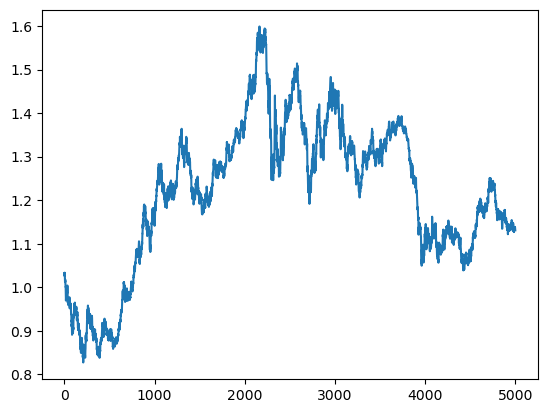

In [14]:
df.columns = ['Date','Cloture', 'Ouverture', 'Plus haut', 'Plus bas', 'Variation']
timeseries = df["Cloture"].values.astype('float32')
plt.plot(timeseries)
plt.show()
# Ordonnées : Clotures
# Abscisse : Time step

In [15]:
# Usually a time series should be “detrended” to remove the linear trend component and normalized before processing. For simplicity, these are skipped in this project.

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
close_price = df["Cloture"].values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [25]:
seq_len = 60

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_close, seq_len, train_frac=0.8)

In [26]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))

In [27]:
batch_size = 500

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/20
7/7 [==============================] - 36s 4s/step - loss: 0.0513 - val_loss: 0.0222
Epoch 2/20
7/7 [==============================] - 18s 3s/step - loss: 0.0773 - val_loss: 0.0194
Epoch 3/20
7/7 [==============================] - 22s 3s/step - loss: 0.0091 - val_loss: 0.0144
Epoch 4/20
7/7 [==============================] - 24s 3s/step - loss: 0.0201 - val_loss: 0.0048
Epoch 5/20
7/7 [==============================] - 22s 3s/step - loss: 0.0077 - val_loss: 0.0062
Epoch 6/20
7/7 [==============================] - 26s 4s/step - loss: 0.0077 - val_loss: 0.0022
Epoch 7/20
7/7 [==============================] - 26s 4s/step - loss: 0.0051 - val_loss: 0.0026
Epoch 8/20
7/7 [==============================] - 26s 4s/step - loss: 0.0034 - val_loss: 0.0016
Epoch 9/20
7/7 [==============================] - 28s 4s/step - loss: 0.0047 - val_loss: 0.0030
Epoch 10/20
7/7 [==============================] - 27s 4s/step - loss: 0.0037 - val_loss: 0.0020
Epoch 11/20
7/7 [======================

31/31 [==============================] - 5s 91ms/step


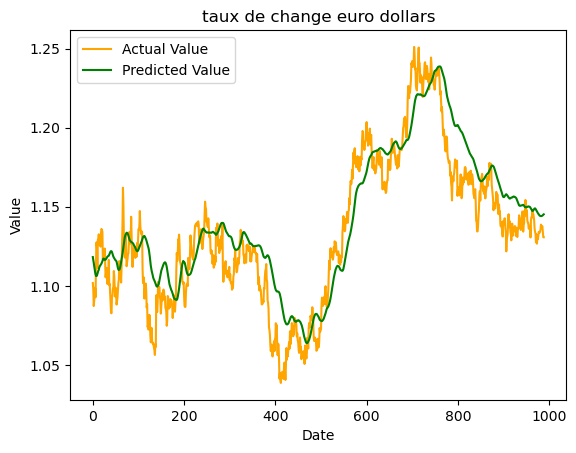

In [28]:
y_pred = model.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label='Actual Value', color='orange')
plt.plot(y_pred_orig, label='Predicted Value', color='green')
 
plt.title('taux de change euro dollars')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')

plt.show();

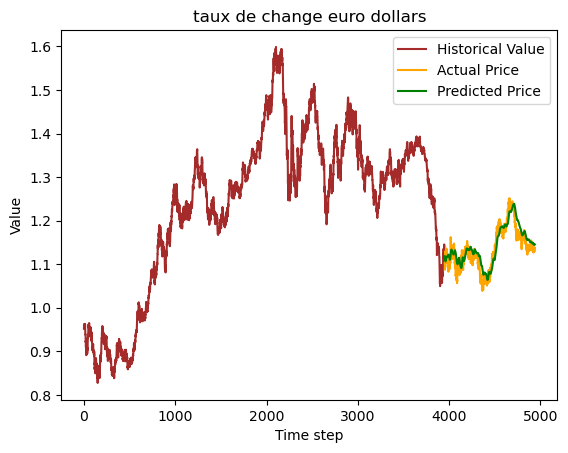

In [29]:
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Value')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Price')

plt.title('taux de change euro dollars')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.show();